<a href="https://colab.research.google.com/github/NachoDave/Automated-Vehicle-Anomalous-Driving-Behaviour/blob/main/CAMs_Autoencoder_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder project

## What do we need to do?


1.   Get and format the data
2.   Split the data into training, test and validation sets - initially will just add the data one measure at a time, but may need to combine them somehow
3. Define the model
4. Crea



### Import Libraries and connect to drive

In [2]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import sys
dataset_dir = '/content/drive/MyDrive/datasets/car_hacking'
sys.path.append(dataset_dir)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [3]:
# from google.colab import drive

# drive.mount('/content/drive')

### Load the datasets

In [4]:
## Function to load the normal da


# Load normal data
normal_df = load_canbus_text_file(f"{dataset_dir}/normal_run_data.txt")
#print(normal_df.head())
#normal_df.to_csv(f"{dataset_dir}/normal_run_data.csv", index=False)

# DoS data
fuzz_df = pd.read_csv(f"{dataset_dir}/Fuzzy_dataset.csv", header=None, on_bad_lines='skip',)
#fuzz_df.head()

# Fuzzy Data
DoS_df = pd.read_csv(f"{dataset_dir}/DoS_dataset.csv", header=None)
#DoS_df
#DoS_df.head()

# RPM Data
rpm_df = pd.read_csv(f"{dataset_dir}/RPM_dataset.csv", header=None)
#print(rpm_df.head())

# Gear dataset
gear_df = pd.read_csv(f"{dataset_dir}/gear_dataset.csv", header=None, on_bad_lines='skip')
#print(gear_df.head())



/tmp/ipython-input-5149133.py:10: DtypeWarning: Columns (6,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  fuzz_df = pd.read_csv(f"{dataset_dir}/Fuzzy_dataset.csv", header=None, on_bad_lines='skip',)
/tmp/ipython-input-5149133.py:23: DtypeWarning: Columns (3,4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  gear_df = pd.read_csv(f"{dataset_dir}/gear_dataset.csv", header=None, on_bad_lines='skip')


In [5]:
normal_df['ID'].nunique(), fuzz_df[1].nunique(), DoS_df[1].nunique(), rpm_df[1].nunique(), gear_df[1].nunique()

(27, 2048, 27, 26, 26)

In [6]:
(normal_df['ID'].value_counts())

,count
ID,
02c0,50689
018f,50687
0260,50687
02a0,50687
0316,50687
0329,50686
0545,50686
0350,50661
0131,50647


In [17]:
gear_df[1].value_counts().transpose()#, #.nunique()#, rpm_df[1].nunique(), normal_df['ID'].nunique()

,count
1,
043f,661388
0316,141160
018f,141110
0002,139773
0260,139658
0153,139308
02a0,138503
0370,138224
02c0,138060


In [8]:
fuzz_df[1].unique(), DoS_df[1].unique(), rpm_df[1].unique(),normal_df['ID'].unique()

(array(['0545', '02b0', '0002', ..., '0524', '00d6', '0038'], dtype=object),
 array(['0316', '018f', '0260', '02a0', '0329', '0545', '0002', '0153',
        '02c0', '0130', '0131', '0140', '0350', '043f', '0370', '0440',
        '04f0', '0430', '04b1', '01f1', '05f0', '00a0', '00a1', '0690',
        '05a0', '05a2', '0000'], dtype=object),
 array(['0316', '018f', '0260', '02a0', '0329', '0545', '02c0', '0002',
        '0153', '0130', '0131', '0140', '043f', '0370', '0440', '0350',
        '04f0', '0430', '04b1', '01f1', '0690', '05f0', '00a0', '00a1',
        '05a0', '05a2'], dtype=object),
 array(['0350', '02c0', '0430', '04b1', '01f1', '0153', '0002', '018f',
        '0130', '0131', '0140', '0260', '02a0', '0316', '0329', '0545',
        '02b0', '043f', '0370', '0440', '04f0', '05f0', '05a0', '05a2',
        '0690', '00a0', '00a1'], dtype=object))

In [9]:
## Sample the dodgy data sets
fuzz_df1 = fuzz_df.sample(n = 148331, random_state=42)
DoS_df1 = DoS_df.sample(n = 148331, random_state=42)
rpm_df1 = rpm_df.sample(n = 148331, random_state=42)
gear_df1 = gear_df.sample(n = 148331, random_state=42)

DoS_injections = DoS_df1[1] == '0000'

In [29]:
#fuzz_df[0].max(), fuzz_df[0].min(), normal_df['Timestamp'].max(), normal_df['Timestamp'].min(

,0,1,2,3,4,5,6,7,8,9,10,11
1707766,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,R
89510,1.478196e+09,02b0,5,ff,7f,00,5.0,85,R,1478196153.498813,056c,8.0
1144898,1.478198e+09,0370,8,00,20,00,00,00,00,00,00,R
220615,1.478197e+09,02a0,8,24,00,9a,1d,97,02,bd,00,R
1109725,1.478198e+09,0545,8,d8,00,00,88,00,00,00,00,R
...,...,...,...,...,...,...,...,...,...,...,...,...
1544436,1.478201e+09,0130,8,03,80,00,ff,02,80,06,6f,R
812376,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
66706,1.478196e+09,02b0,5,00,00,00,7.0,07,R,1478195804.935391,0370,8.0
1413112,1.478201e+09,0350,8,05,20,44,68,74,00,00,7d,R


In [10]:
DoS_injections

,1
2771604,False
2858691,False
2578057,False
2269155,False
2965992,False
...,...
3060968,False
129684,True
1435596,True
3527892,False


In [11]:
from datetime import time
fuzz_time = fuzz_df.iloc[:,0].diff().dropna()
fuzz_time = pd.DataFrame({'TS':fuzz_time, 'Label':'Fuzzy'})
DoS_time = DoS_df.iloc[:,0].diff().dropna()
DoS_time = pd.DataFrame({'TS':DoS_time, 'Label':'DoS'})
normal_time = normal_df.iloc[:,0].astype('float').diff().dropna()
normal_time = pd.DataFrame({'TS':normal_time, 'Label':'Normal'})
RPM_time = rpm_df.iloc[:,0].diff().dropna()
RPM_time = pd.DataFrame({'TS':RPM_time, 'Label':'RPM'})

time_stamp = pd.concat([normal_time, DoS_time, RPM_time, fuzz_time], axis=0)
time_stamp = time_stamp[time_stamp['TS'] < 0.05]

In [16]:
#len(fuzz_df)/(fuzz_df.iloc[:,0].max() - fuzz_df.iloc[:,0].min())
#len(rpm_df)/(rpm_df.iloc[:,0].max() - rpm_df.iloc[:,0].min())
#len(normal_df)/(normal_df.iloc[:,0].astype('float').max() - normal_df.iloc[:,0].astype('float').min())
#len(DoS_df)/(DoS_df.iloc[:,0].max() - DoS_df.iloc[:,0].min())

(DoS_df.iloc[:,0].max() - DoS_df.iloc[:,0].min())

2832.6695170402527

KeyboardInterrupt: 

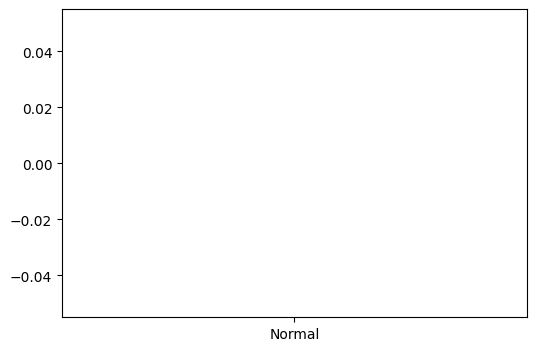

In [13]:

# #plt.figure(figsize=(10, 6))
# plt.figure(figsize=(6, 4))
# #sns.histplot( x='Error', data=x3, hue='Label')
# sns.boxplot( y='TS', data=time_stamp, x='Label')
# plt.title('Time Between CAN-BUS Signals')
# plt.ylabel('Time between Signals (S)')
# plt.xlabel('Data set')
# plt.grid(True)
# plt.tight_layout()
# plt.ylim(-0.0001,0.001)
# plt.show()

In [ ]:
## Value counts for the CAN Bus IDs
#normal_df['ID'].value_counts() #> 50000

high_freq_entries = normal_df['ID'].value_counts()
normal_can_bus_IDs = high_freq_entries[high_freq_entries > 50000].index.tolist()


## Formatted datasets

In [30]:
normal_data = format_CAN_bus_data(normal_df, normal_can_bus_IDs)
fuzz_data = format_CAN_bus_data(fuzz_df1, normal_can_bus_IDs)
DoS_data = format_CAN_bus_data(DoS_df1, normal_can_bus_IDs)
rpm_data = format_CAN_bus_data(rpm_df1, normal_can_bus_IDs)
gear_data = format_CAN_bus_data(gear_df1, normal_can_bus_IDs)

rpm_data.head()

NameError: name 'normal_can_bus_IDs' is not defined

In [ ]:
normal_data = normal_data.astype("float32")
fuzz_data = fuzz_data.astype("float32")
DoS_data = DoS_data.astype("float32")
rpm_data = rpm_data.astype("float32")
gear_data = gear_data.astype("float32")

In [ ]:
normal_data

### Get data ready for loading

In [ ]:
X = normal_data.astype("float32")   # convert to float 32
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42) # create training set
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42) # create validation and training set

### Create the autoencoder

In [ ]:
## Autoencoder class
class AutoencoderModel:
  def __init__(self, input_output_dim, encod_decod_dim, latent_dim, activations, output_activation, latent_activation, optimizer, loss, encode_dropout = False, decode_dropout = False, vae = False, vae_beta = 1):
    self.input_output_dim = input_output_dim
    self.latent_dim = latent_dim
    self.activations = activations
    self.encod_decod_dim = encod_decod_dim
    self.output_activation = output_activation
    self.latent_activation = latent_activation
    self.optimizer = optimizer
    self.loss = loss
    self.encode_dropout = encode_dropout
    self.decode_dropout = decode_dropout
    self.vae = vae
    self.vae_beta = vae_beta
    self.inference_errors = {}
    self.training_history = None
    self.model = self._build_model()

  def _build_model(self):
    ## Input layer
    input_layer = layers.Input(shape=(self.input_output_dim,)) # assign the input layer
    x = input_layer

    ## Build the encoder
    for i in range(len(self.activations)):
      x = layers.Dense(self.encod_decod_dim[i], activation=self.activations[i])(x)
      if self.encode_dropout:
        x = layers.Dropout(self.encode_dropout)(x)


    # Latent space
    if self.vae:
      z_mean = layers.Dense(self.latent_dim)(x)
      z_log_var = layers.Dense(self.latent_dim)(x)
      z = SamplingLayer(beta=self.vae_beta)([z_mean, z_log_var])
      latent = z
    else:
      latent = layers.Dense(self.latent_dim, activation=self.latent_activation)(x)


    ## Build the decoder
    x = latent
    for i in range(len(self.activations)-1, -1, -1):
      x = layers.Dense(self.encod_decod_dim[i], activation=self.activations[i])(x)
      if self.decode_dropout:
        x = layers.Dropout(self.decode_dropout)(x)

    ## Output layer
    output_layer = layers.Dense(self.input_output_dim, activation=self.output_activation)(x)

    ## Create the model
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

    return autoencoder

  ## Fit the model
  def fit(self, X_train, X_val, epochs, batch_size, shuffle = True, verbose = True, call_backs = [], **kwargs):
    self.training_history = self.model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=shuffle,
        validation_data=(X_val, X_val),
        verbose = verbose,
        callbacks = call_backs,
        **kwargs
    )

  ## Plot loss
  def plot_loss(self):
        import matplotlib.pyplot as plt
        if self.training_history.history:
            plt.plot(self.training_history.history['loss'], label='Training Loss')
            plt.plot(self.training_history.history['val_loss'], label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training vs Validation Loss')
            plt.grid(True)
            plt.show()
        else:
            print("Model has not been trained yet.")

  ## Inference
  def infer(self, X, inf_name, cats = None):
        """
        Returns reconstructed output and reconstruction error for input X.
        """
        # get the bus IDs
        busErrDict = {'BUS ID': X.iloc[:, 0:18].idxmax(axis=1)}


        import numpy as np
        reconstructed = self.model.predict(X)
        busErrDict['MSE Error'] = np.mean(np.square(X - reconstructed), axis=1)
        busErrDict['MAE Error'] = np.mean(np.abs(X - reconstructed), axis=1)
        busErrDict['Label'] = inf_name

        busErrDf = pd.DataFrame(busErrDict)
        self.inference_errors[inf_name] = busErrDf

        return reconstructed, busErrDf





In [ ]:
# VAE sampling class

class SamplingLayer(layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(SamplingLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(self.beta * kl_loss)
        return z


In [ ]:
#del m1
m1 = AutoencoderModel(26, [64,32], 16, ['relu', 'relu'], 'sigmoid', 'relu','adam', 'mse', encode_dropout = False, decode_dropout = False, vae = False)
m1.model.summary()

### Train the model

In [ ]:
#%%timeit
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
m1.fit(X_train, X_val, epochs = 20, batch_size = 128, call_backs = [callback])


In [ ]:
import matplotlib.pyplot as plt

plt.plot(m1.training_history.history['loss'], label='Training Loss')
plt.plot(m1.training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
m1.infer(X_test, 'Test')
m1.infer(rpm_data, 'rpm')
m1.infer(fuzz_data, 'fuzzy')
m1.infer(DoS_data, 'DoS')

In [ ]:
test_infer = m1.inference_errors['Test'].copy()
rpm_infer = m1.inference_errors['rpm'].copy()
fuzz_infer = m1.inference_errors['fuzzy'].copy()
DoS_infer = m1.inference_errors['DoS'].copy()

In [ ]:
test_infer['BUS ID Cat'] = pd.Categorical(test_infer['BUS ID'], categories=X_test.columns[0:18])
rpm_infer['BUS ID Cat'] = pd.Categorical(rpm_infer['BUS ID'], categories=X_test.columns[0:18])
fuzz_infer['BUS ID Cat'] = pd.Categorical(fuzz_infer['BUS ID'], categories=X_test.columns[0:18])
DoS_infer['BUS ID Cat'] = pd.Categorical(DoS_infer['BUS ID'], categories=X_test.columns[0:18])

In [ ]:
x3[x3['BUS ID'] == '02c0']['Error'].unique(), y3[y3['BUS ID'] == '02c0']['Error'].unique()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot( x='MSE Error', data=test_infer)
#sns.boxplot( y='Error', data=y3, x='BUS ID')
plt.title('Reconstruction Error Distribution by Scenario')
plt.ylabel('Reconstruction Error')
plt.xlabel('Recon')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
X_test.columns[0:18]

In [ ]:
plt.figure(figsize=(10, 6))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=test_infer, x='BUS ID Cat')
plt.title('Reconstruction Error Distribution by Scenario Test Set')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=rpm_infer, x='BUS ID Cat')
plt.title('Reconstruction Error Distribution by Scenario RPM')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=fuzz_infer, x='BUS ID Cat')
plt.title('Reconstruction Error Distribution by Scenario Fuzzy Attack')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=DoS_infer, x='BUS ID Cat')
plt.title('Reconstruction Error Distribution by Scenario DoS')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
test_rpm_infer = data=pd.concat([test_infer,rpm_infer])
test_rpm_infer.loc[test_rpm_infer['BUS ID'] != '0316', 'BUS ID'] = 'Other'
#
#plt.figure(figsize=(10, 6))
plt.figure(figsize=(6, 4))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=test_rpm_infer, x='BUS ID', hue='Label')
plt.title('Reconstruction Error Test vs RPM Attack')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_Fuzz_infer = data=pd.concat([test_infer,fuzz_infer])
test_Fuzz_infer = test_Fuzz_infer[test_Fuzz_infer['BUS ID'] == '9999']

plt.figure(figsize=(6, 4))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=test_Fuzz_infer, x='BUS ID', hue='Label')
plt.title('Reconstruction Error Test vs Fuzzy Attack')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.05,0.3)
plt.show()

In [ ]:
test_infer.loc[test_infer['BUS ID'] == '9999', 'MSE Error'].shape,DoS_infer.loc[DoS_infer['BUS ID'] == '9999', 'MSE Error'].shape

In [ ]:
test_DoS_infer = data=pd.concat([test_infer,DoS_infer])
test_DoS_infer = test_DoS_infer[test_DoS_infer['BUS ID'] == '9999']

plt.figure(figsize=(10, 6))
#plt.figure(figsize=(6, 4))
#sns.histplot( x='Error', data=x3, hue='Label')
sns.boxplot( y='MSE Error', data=test_DoS_infer, x='BUS ID', hue='Label')
plt.title('Reconstruction Error Test vs DoS Attack')
plt.ylabel('Reconstruction Error')
plt.xlabel('Bus')
plt.grid(True)
plt.tight_layout()
#plt.ylim(-0.05,0.5)
plt.show()

In [ ]:
thres = test_infer.loc[test_infer['BUS ID'] == '9999', 'MSE Error'].quantile(0.95)

DoS_infer['Injection'] = DoS_injections
DoS_infer_9999 =  DoS_infer[DoS_infer['BUS ID'] == '9999']


DoS_infer_9999['Prediction'] = 0
#DoS_infer_9999.loc[DoS_infer_9999['MSE Error'] < thres, 'Prediction'] = 1

DoS_infer_9999['Prediction'].value_counts()
thres